In [6]:
from pathlib import Path
import sys

import pandas as pd

sys.path.append(str(Path.cwd().parent))
from utils import norm_probs

In [7]:
DATA_PATH = Path('../data/')
METAMODEL_DATA_PATH = Path('../metamodel/train-data/')

In [8]:
# Read reference data
ref_df = pd.read_csv(DATA_PATH / 'share'/ 'train.csv', index_col='line_id')

scores = {'accuracy': [], 'threshold': []}
model_names = []
for model_path in [path for path in METAMODEL_DATA_PATH.iterdir() if path.is_dir()]:
    for file_path in [path for path in model_path.iterdir() if path.is_file()]:
        # Read model predition data
        model_df = pd.read_csv(file_path, index_col='line_id')
        
        # Calculate hallucination probs
        if 'p(Entl)' in model_df:
            model_df['p(Halluc)'] = model_df.apply(lambda x: norm_probs(x['p(Contr)'], x['p(Entl)'])[0], axis=1)
            model_df.drop(columns=['p(Entl)'], inplace=True)
        else:
            model_df['p(Halluc)'] = model_df['p(Contr)']
        model_df.drop(columns=['p(Contr)'], inplace=True)

        # Find best threshold and calculate accuracy
        if model_df['p(Halluc)'].nunique() > 3:
            best_threshold, best_accuracy = 0., 0.
            for threshold in [x / 100. for x in range(101)]:
                # Calculate accuracy
                accuracy = ((model_df['p(Halluc)'] > threshold) == ref_df['is_hallucination']).sum() / len(model_df)
                
                # Update best values
                if accuracy > best_accuracy:
                    best_threshold, best_accuracy = threshold, accuracy
        else:
            threshold = 0.5
            accuracy = ((model_df['p(Halluc)'] > threshold) == ref_df['is_hallucination']).sum() / len(model_df)
            best_threshold, best_accuracy = threshold, accuracy

        scores['threshold'].append(best_threshold)
        scores['accuracy'].append(best_accuracy)
        model_names.append(f'{model_path.parts[-1]}')
        print(file_path)

../metamodel/train-data/ivankud-deberta-v2-xlarge-mnli/probs.csv
../metamodel/train-data/ivankud-deberta-v3-large-tasksource-nli/probs.csv
../metamodel/train-data/ivankud-DeBERTa-v3-large-mnli-fever-anli-ling-wanli/probs.csv


In [9]:
result = pd.DataFrame(scores, index=model_names)

pd.set_option('display.max_rows', 100)
result.sort_values('accuracy', ascending=False)

,accuracy,threshold
ivankud-deberta-v3-large-tasksource-nli,0.950476,0.32
ivankud-DeBERTa-v3-large-mnli-fever-anli-ling-wanli,0.935238,0.39
ivankud-deberta-v2-xlarge-mnli,0.930476,0.27


# Plot Accuracy vs Threshold

best_threshold=0.39
best_accuracy=0.9352380952380952


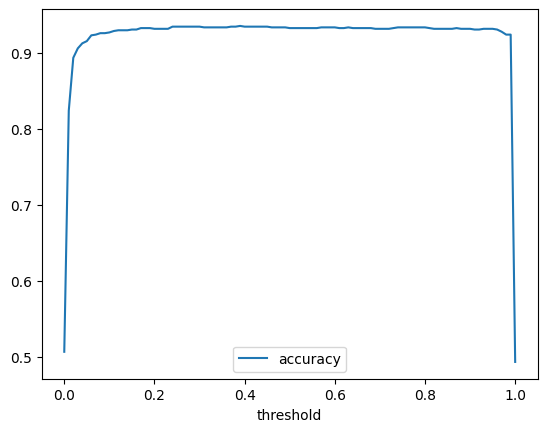

In [10]:
model_df = pd.read_csv(METAMODEL_DATA_PATH / 'ivankud-DeBERTa-v3-large-mnli-fever-anli-ling-wanli' / 'probs.csv', index_col='line_id')

# Calculate hallucination probs
if 'p(Entl)' in model_df:
    model_df['p(Halluc)'] = model_df.apply(lambda x: norm_probs(x['p(Contr)'], x['p(Entl)'])[0], axis=1)
    model_df.drop(columns=['p(Entl)'], inplace=True)
else:
    model_df['p(Halluc)'] = model_df['p(Contr)']
model_df.drop(columns=['p(Contr)'], inplace=True)

# Find best threshold
score = {'threshold': [], 'accuracy': []}
best_threshold, best_accuracy = 0., 0.
for threshold in [x / 100. for x in range(101)]:
    accuracy = ((model_df['p(Halluc)'] > threshold) == ref_df['is_hallucination']).sum() / len(model_df)
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy
    score['threshold'].append(threshold)
    score['accuracy'].append(accuracy)

pd.DataFrame(score).plot('threshold', 'accuracy')
print(f'{best_threshold=}\n{best_accuracy=}')